https://github.com/sflydatascience/homework1

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Explore Online

#### Basic Data Quality Checks and Summary

In [4]:
online = pd.read_csv('data/online.csv')

In [59]:
online['dt'] = pd.to_datetime(online['dt'])

In [60]:
online.head()

,session,visitor,dt,custno,category,event1,event2
0,419542,140970,2016-09-16 05:03:23,3840,1,NaN,1
1,3030130,14501,2017-11-13 04:58:12,70400,1,NaN,1
2,2638740,419353,2017-05-24 16:10:38,21248,1,NaN,1
3,880408,90673,2017-10-28 13:42:38,39168,1,NaN,1
4,2612179,191542,2016-05-17 06:30:32,47616,1,NaN,1


In [54]:
online.isna().sum()

session          0
visitor          0
dt               0
custno           0
category         0
event1      789846
event2           0
dtype: int64

In [54]:
online.isna().sum()

session          0
visitor          0
dt               0
custno           0
category         0
event1      789846
event2           0
dtype: int64

#### Number of Sessions Over TIme

In [70]:
online['date'] = online['dt'].dt.date
unique_sessions = online[['date', 'session']].drop_duplicates()
sessions_per_day = unique_sessions.groupby('date').count()

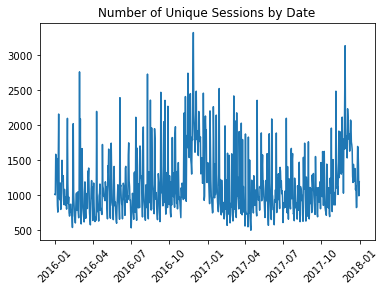

In [81]:
plt.plot(sessions_per_day)
plt.title('Number of Unique Sessions by Date')
plt.xticks(rotation=45)
plt.show()

#### Distince Customers

#### Evaluate Event 1

In [43]:
event_1_counts = online.groupby('event1').count()['session']

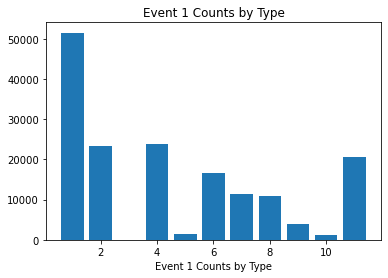

In [46]:
plt.bar(event_1_counts.index, event_1_counts)
plt.title('Event 1 Counts by Type')
plt.xlabel('Event 1 Counts by Type')
plt.show()

#### Evaluate Event 2

In [50]:
event_2_counts = online.groupby('event2').count()['session']

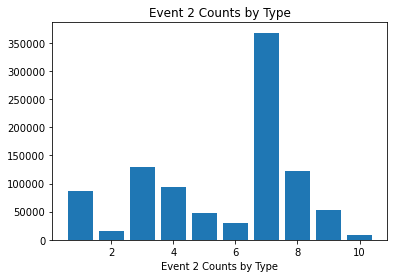

In [51]:
plt.bar(event_2_counts.index, event_2_counts)
plt.title('Event 2 Counts by Type')
plt.xlabel('Event 2 Counts by Type')
plt.show()

# Explore order.csv

In [6]:
order = pd.read_csv('data/order.csv')

In [82]:
order.head()

,custno,ordno,orderdate,prodcat2,prodcat1,revenue
0,18944,64694,2016-11-27 20:57:20,NaN,1,53.30
1,18944,114405,2017-04-29 20:18:04,NaN,1,0.10
2,18944,28906,2017-04-23 21:31:03,NaN,1,141.66
3,36096,62681,2016-02-25 07:16:33,NaN,1,36.82
4,1,1,2017-06-12 08:27:59,NaN,1,8.35


#### Distribution of Revenue by Category 

#### Which Products Tend to be Purchased Together

In [25]:
n_records_by_session = online.groupby('session').count()[['custno', 'visitor']]

In [34]:
online[online['session'] == 72733]

,session,visitor,dt,custno,category,event1,event2
228862,72733,309625,2017-01-29 09:57:22,59156,3,NaN,3
333791,72733,309625,2017-01-29 09:44:33,59156,3,NaN,4
464634,72733,309625,2017-01-29 09:14:43,59156,3,NaN,7
656378,72733,309625,2017-01-29 09:18:36,59156,3,NaN,8
749829,72733,309625,2017-01-29 09:46:58,59156,3,NaN,9


In [33]:
n_records_by_session[n_records_by_session['custno']>4]

,custno,visitor
session,,
72733,5,5
157423,5,5
161973,5,5
692928,5,5
811699,5,5
1178030,5,5
1564273,5,5
1588057,5,5
1635458,5,5


In [14]:
online[online['session']==3030130]

,session,visitor,dt,custno,category,event1,event2
1,3030130,14501,2017-11-13 04:58:12,70400,1,NaN,1


In [11]:
online.groupby('category').count()

,session,visitor,dt,custno,event1,event2
category,,,,,,
1,52964,52964,52964,52964,11330,52964
2,194890,194890,194890,194890,55558,194890
3,706920,706920,706920,706920,98040,706920


In [9]:
online.groupby('event1').count()

,session,visitor,dt,custno,category,event2
event1,,,,,,
1.0,51567,51567,51567,51567,51567,51567
2.0,23312,23312,23312,23312,23312,23312
4.0,23858,23858,23858,23858,23858,23858
5.0,1473,1473,1473,1473,1473,1473
6.0,16537,16537,16537,16537,16537,16537
7.0,11416,11416,11416,11416,11416,11416
8.0,10966,10966,10966,10966,10966,10966
9.0,3990,3990,3990,3990,3990,3990
10.0,1223,1223,1223,1223,1223,1223


In [10]:
online.groupby('event2').count()

,session,visitor,dt,custno,category,event1
event2,,,,,,
1,86496,86496,86496,86496,86496,30547
2,15419,15419,15419,15419,15419,4260
3,129795,129795,129795,129795,129795,1333
4,94230,94230,94230,94230,94230,2485
5,48282,48282,48282,48282,48282,3687
6,29913,29913,29913,29913,29913,413
7,367857,367857,367857,367857,367857,115098
8,122402,122402,122402,122402,122402,1838
9,52145,52145,52145,52145,52145,815


In [8]:
order.groupby('prodcat2').count()

,custno,ordno,orderdate,prodcat1,revenue
prodcat2,,,,,
2.0,5148,5148,5148,5148,5148
3.0,40908,40908,40908,40908,40908
4.0,15797,15797,15797,15797,15797
5.0,12946,12946,12946,12946,12946
6.0,5393,5393,5393,5393,5393
...,...,...,...,...,...
259.0,5,5,5,5,5
260.0,1,1,1,1,1
261.0,1,1,1,1,1
